### SJF Scheduling with Neural Networks (for burst-time)

#### Import Dependencies

In [1]:
from utils import InputData
from kmodel import NeuralNet3L
from scheduler import SJF

from utils import InputData
from keras.models import Sequential
from keras.layers import Dense

import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

Using TensorFlow backend.


#### Load Training Data

In [2]:
inp_data = InputData("data/anon_jobs.db3")
train_data = inp_data.get_data()

#### Plot Some Paramaters

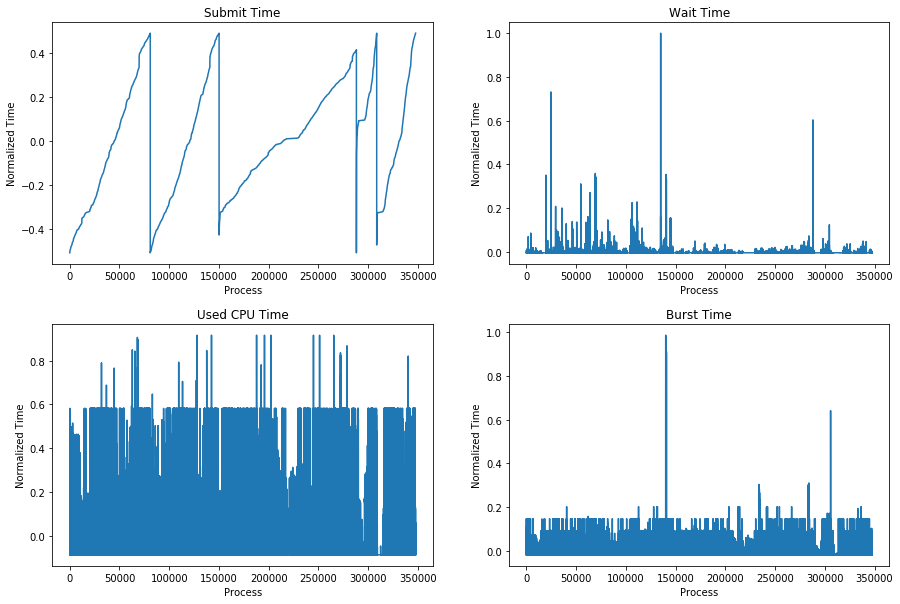

In [3]:
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.25)

ax = fig.add_subplot(2,2,1)
plt.xlabel('Process')
plt.ylabel('Normalized Time')
plt.title('Submit Time')
_ = ax.plot(train_data['input'][:,0])

ax = fig.add_subplot(2,2,2)
plt.xlabel('Process')
plt.ylabel('Normalized Time')
plt.title('Wait Time')
_ = ax.plot(train_data['input'][:,1])

ax = fig.add_subplot(2,2,3)
plt.xlabel('Process')
plt.ylabel('Normalized Time')
plt.title('Used CPU Time')
_ = ax.plot(train_data['input'][:,2])

ax = fig.add_subplot(2,2,4)
plt.xlabel('Process')
plt.ylabel('Normalized Time')
plt.title('Burst Time')
_ = ax.plot(train_data['target'])

#### Train Neural Network (3 layers)

In [4]:
features = train_data['input']
target = train_data['target']

model = NeuralNet3L()
history = model.fit(features, target, epochs=10, batch_size=100)

Train on 295469 samples, validate on 52142 samples
Epoch 1/10
295469/295469 [==============================] - 15s - loss: 4.8521e-04 - val_loss: 0.0250
Epoch 2/10
295469/295469 [==============================] - 14s - loss: 1.3901e-04 - val_loss: 0.0054
Epoch 3/10
295469/295469 [==============================] - 14s - loss: 1.2501e-04 - val_loss: 0.0019
Epoch 4/10
295469/295469 [==============================] - 14s - loss: 1.2070e-04 - val_loss: 5.5820e-04
Epoch 5/10
295469/295469 [==============================] - 14s - loss: 1.1565e-04 - val_loss: 3.2385e-04
Epoch 6/10
295469/295469 [==============================] - 14s - loss: 1.1271e-04 - val_loss: 2.0889e-04
Epoch 7/10
295469/295469 [==============================] - 14s - loss: 1.1086e-04 - val_loss: 2.2094e-04
Epoch 8/10
295469/295469 [==============================] - 14s - loss: 1.0959e-04 - val_loss: 1.9553e-04
Epoch 9/10
295469/295469 [==============================] - 14s - loss: 1.0883e-04 - val_loss: 1.7648e-04
Epoch 1

#### Plot Losses

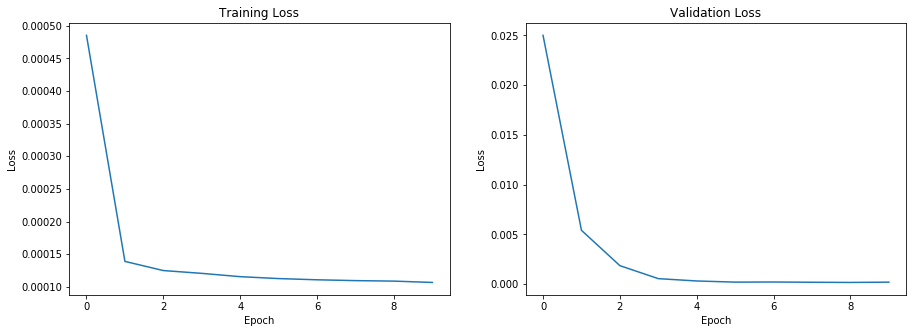

In [5]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
_ = ax.plot(history.history['loss'])

ax = fig.add_subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
_ = ax.plot(history.history['val_loss'])

#### Sample Test Data from validation set

In [6]:
test_data = {}
rs = random.randint(0, int(train_data['input'].shape[0] * 1))
test_data['input'] = train_data['input'][-rs:-rs+10]
test_data['target'] = train_data['target'][-rs:-rs+10]
test_data['normalizer'] = train_data['normalizer']

# test_data = inp_data.sample_data(size=10)

#### Predict Burst time

In [7]:
pred = model.predict(test_data['input'])
real = test_data['target']

#### Plot difference

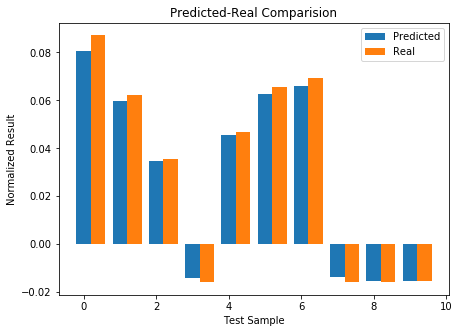

In [8]:
fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(1,1,1)
plt.xlabel('Test Sample')
plt.ylabel('Normalized Result')
plt.title('Predicted-Real Comparision')
rects1 = ax.bar([x for x in range(len(pred))], pred, width=0.40)
rects2 = ax.bar([x+0.40 for x in range(len(real))], real, width=0.40)
_ = ax.legend((rects1[0], rects2[0]), ('Predicted', 'Real'))

#### Get start time and burts time from data

In [9]:
normalizer = test_data['normalizer']
start_time = inp_data.denormalize(test_data['input'][:,0], normalizer['SubmitTime']) 
burst_time = inp_data.denormalize(pred, normalizer['RunTime'])
start_time = [(x - test_data['normalizer']['SubmitTime']['min'])/1000 for x in start_time]
burst_time = [x/1000 if x > 10 else 0.01 for x in burst_time]

#### schedule process

In [10]:
scheduler = SJF()
result = scheduler.schedule(start_time, burst_time)

#### Show scheduling result

In [11]:
print("Average Turnaround Time : " + str(result['average_turnaround_time']))
print("Average Waiting Time : " + str(result['average_waiting_time']))

q = result['queues']
process = []

for i in range(len(q)):
    for j in range(len(q[i])):
        process.append([i, q[i][j].id, q[i][j].at, q[i][j].bt, q[i][j].wt, q[i][j].tat])

pd.DataFrame(process, columns=['Queue', 'Id', 'Arival Time', 'Burst Time', 'Waiting Time', 'Turnaround Time'])

Average Turnaround Time : 124.483674219
Average Waiting Time : 53.4618


Queue  Id  Arival Time  Burst Time  Waiting Time  Turnaround Time
0      0   0    30219.603  152.038234         0.397       152.435234
1      1   1    30220.082  119.391141         0.918       120.309141
2      1   7    30224.923    3.863090       116.077       119.940090
3      1   8    30226.157    1.169344       118.843       120.012344
4      1   9    30229.808    1.167291       117.192       118.359291
5      2   2    30220.862   79.842141         0.138        79.980141
6      2   5    30224.056  123.995688        76.944       200.939687
7      3   3    30221.288    3.161986         0.712         3.873986
8      3   4    30221.487   96.689281         4.513       101.202281
9      3   6    30224.116  128.900547        98.884       227.784547